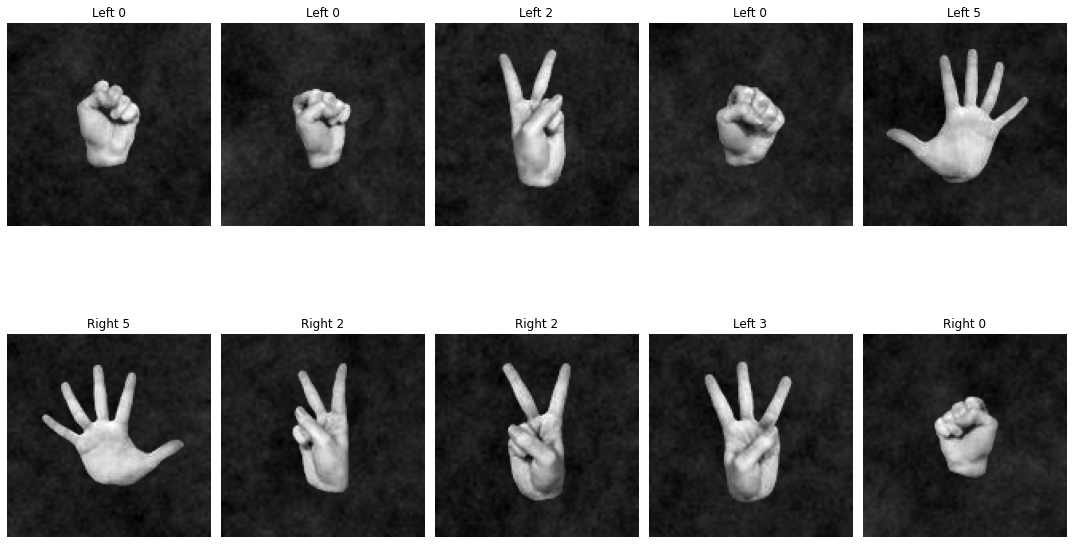

In [1]:
import os
from PIL import Image
import matplotlib.pyplot  as plt

def visua_img(file_path,n=10):
    
    img_list=os.listdir(file_path)
    fig,ax=plt.subplots(n//5,5,figsize=(15,10))
    
    for i,img_name in enumerate(img_list[:n]):
        img= Image.open(file_path+img_name)
        n_label=img_name[-6]
        hand_label=img_name[-5]
        ax[i//5][i%5].imshow(img,cmap='gray')
        ax[i//5][i%5].axis('off')
        ax[i//5][i%5].set_title('{} {}'.format( 'Left' if hand_label=='L' else 'Right',n_label))
    plt.tight_layout()
    plt.show()
visua_img('./train/',10)

In [ ]:
import torch
torch.cuda.empty_cache()

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot  as plt

from torch import nn

seed = torch.initial_seed()

train_batch_size = 36  # Define train batch size
test_batch_size = 120  # Define test batch size (can be larger than train batch size)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'
print(device)



# define class to build dataset
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self,file_path,transform):
        self.file_path=file_path
        self.transform=transform
        self.image_list= os.listdir(file_path)       # list of image names
        random.shuffle(self.image_list)
        
    def __getitem__(self, idx):

        image_name = self.image_list[idx]
        # label 1 for left or right hand, label 2 for fingers count
        # label 1 : 'L' for 1, and 'R' for 0
        data, label1, label2 = Image.open(self.file_path+image_name), image_name[-5:-4], image_name[-6:-5]   
        label1 = int(label1=='L')
        label2= int(label2)

        return self.transform(data).to(device), torch.tensor(label1).to(device), torch.tensor(label2).to(device)
    
    def __len__(self):
        return len(self.image_list)
    
trf = T.Compose([T.ToTensor(), 
             T.Normalize((0.5,),(0.5,))])
train_dataset=BuildDataset('./train/',trf)
test_dataset=BuildDataset('./test/',trf)


cpu


In [5]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
)

len_train=len(train_loader)
len_val=len(test_loader)
print(len_train)
print(len_val)

#count=0
#fig,ax=plt.subplots(1,5,figsize=(15,10))
#for i,j in train_loader:
#    img=i[count].squeeze(0)
#    print(img.shape)
#    ax[count].imshow(img.to('cpu').numpy())
#    print(j[count])
#    if count==4:
#        break
#    count+=1

500
30


In [10]:
class MTLNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes_1,num_classes_2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=11, stride=3, padding=0, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, stride=1, padding=2,bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=192, out_channels=72, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
        )
        # decoder 1 for task 1, right or left hand
        self.decoder1=nn.Sequential(
            nn.Dropout(),
            nn.Linear(5*5*36, 3*6*20),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*20, 3*4*8),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*8,num_classes_1),
        )
        # decoder 2 for task 2, fingers count
        self.decoder2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(5*5*72, 3*6*30),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*30, 3*4*8),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*8,num_classes_2),
        )
        
        self.classifier=nn.Softmax(dim=1)

    def forward(self, x, task_num):
        shared = self.encoder(x)
        
        # ---
        # gradient shared w.r.t parameters in encoder
        # ---
        
        task_1 = shared.detach().clone()
        task_2 = shared.detach().clone()
        
        
        # reduce the dimensions for linear layer input
        task_1=task_1.view(task_1.size(0),5*5*36)
        task_1 = self.decoder1(task_1)
        task_1 = self.classifier(task_1)
        
        task_2=task_2.view(task_2.size(0),5*5*72)
        task_2 = self.decoder2(task_2)
        task_2 = self.classifier(task_2)
        
        return task_1, task_2

In [ ]:
import numpy as np
import tqdm

# initialize the number of classes for output
model = MTLNet(2,6)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-6)

epochs = 10

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# every 90 iterations for log
log_interval = 100

loss_list = []
iteration_list = []
accuracy_list = []
count = 0

def _compute_loss()





if __name__ =='__main__':
    for epoch in tqdm.trange(epochs):
        for idx, (data, labels) in enumerate(train_loader):
    
            # Calculate training loss on model
            pred_y = model(data)
            loss = loss_fn(pred_y, labels)
            # zeros gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # save loss and accuracy for every 25 iterations
            if idx % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        idx * train_batch_size,
                        len_train*train_batch_size,
                        100.0 * idx / len_train,
                        loss.item(),
                    )
                )
                loss_list.append(loss.item())
                count += log_interval
                iteration_list.append(count)
                
                # calculate validation accuracy
                with torch.no_grad():
                    n_sample = len_val*test_batch_size
                    n_correct = 0
                    for idxx, (data, labels) in enumerate(test_loader):
                        #data=data.to(device)
                        #labels=labels.to(device)
                        pred_y = model(data).to('cpu')
                        labels=labels.to('cpu')
                        n_correct += sum(
                            (torch.argmax(pred_y, dim=1) == labels).type(torch.FloatTensor)
                        )
                    accuracy_list.append(100.0 * n_correct / n_sample)
                    print(
                        "Validation set: number of correct labels: {}/{} accuracy: ({:.0f}%)\n".format(
                            int(n_correct), n_sample, 100.0 * n_correct / n_sample
                        )
                    )